<img src='../img/dust_banner.png' alt='Training school and workshop on dust' align='center' width='100%'></img>

<br>

# Day 2 - Practical exercise - Solution

### About

> With yesterday’s exercise and assignment #1, you compared two dust forecast models as well as near real-time monitoring with satellite data. From the results of the assignment, you see that it is difficult to know which forecast can be trusted more. Hence, even though model intercomparison is important, model outcomes also have to be compared with real-world observations. Just by comparing model outcomes with measurements from station data, we can better understand how the model performs.
> 
> Today, you will focus on how you can use station observations from AERONET to evaluate model forecasts.



### Tasks

#### 1. Brainstorm
  * What observation datasets do you know about?
  * Which variables do they measure?
  * Which data can you use to evaluate model predictions?
  

#### 2. Download and plot time-series of AERONET data for *Santa Cruz, Tenerife*
  * Download and visualise AERONET v3.0 measurements of the station *Santa Cruz, Tenerife* for 21 to 25 February 2020.
  * **Some questions to reflect on**
    * Under which name is the station listed in AERONET?
    * What average level would you choose?
    * Which days do we have observations for?
  * **Hint** 
    * [AERONET observations - Example notebook](../../dust_workshop_part1/02_ground-based_observations/21_AERONET.ipynb)



#### 3. Resample AERONET data to a 3-hourly resolution
  * Make use of AERONET `index` and `time` columns to create a `DateTimeIndex` in order to resample the observations to a 3-hourly temporal resolution
  * **Hint**
    * you can use the pandas function `to_datetime()` to create a `DateTimeIndex` and the function `resample().mean()` to resample and average the time-series to a given temporal resolution 
  * **Question to reflect on**
    * How many row entries does the resampled data frame have?



#### 4. Load time-series of the forecasts from CAMS and the MONARCH model and compare it with the AERONET observations
  * Interpret the plotting result.
  * Can you make a statement of the performance of the two forecast models?
  * What is your conclusion regarding AERONET observation data?

### Module outline
* [1 - Select latitude / longitude values for AERONET station 'Santa Cruz, Tenerife'](#select_lat_lon)
* [2 - Download and plot time-series of AERONET data](#aeronet)
* [3 - Resample AERONET data to a 3-hourly resolution](#resample_aeronet)
* [4 - Load time series of the forecasts from CAMS and the MONARCH model](#load_model_timeseries)
* [5 - Visually compare model forecasts with AERONET observations](#compare_model_observations)


<hr>

##### Load required libraries

In [8]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as pl
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
import wget
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

##### Load helper functions

In [9]:
%run ../functions.ipynb

<hr>

### <a id='select_lat_lon'></a>1. Select latitude / longitude values for Santa Cruz, Tenerife

You can see an overview of all available AERONET Site Names [here](https://aeronet.gsfc.nasa.gov/cgi-bin/draw_map_display_aod_v3?long1=-180&long2=180&lat1=-90&lat2=90&multiplier=2&what_map=4&nachal=1&formatter=0&level=3&place_code=10&place_limit=0).

In [10]:
lat = 28.473
lon = -16.247

<br>

### <a id='aeronet'></a>2. Download and plot time-series of AERONET data

As a first step, let us create a Python dictionary in which we store all the parameters we would like to use for the request as dictionary keys. You can initiate a dictionary with curled brackets `{}`. Below, we specify the following parameters:
* `endpoint`: Endpoint of the AERONET web service
* `station`: Name of the AERONET station
* `year`: year 1 of interest
* `month`: month 1 of interest
* `day`: day 1 of interest
* `year2`: year 2 of interest
* `month2`: month 2 of interest
* `day2`: day 2 of interest
* `AOD15`: data type, other options include `AOD10`, `AOD20`, etc.
* `AVG`: data format, `AVG=10` - all points, `AVG=20` - daily averages

The keywords below are those we will need for requesting all data points (`AVG=10`) of Aerosol Optical Depth Level 1.5 data for the station Santa Cruz, Tenerife for 21 to 25 February 2020.

In [11]:
data_dict = {
    'endpoint': 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3',
    'station':'Santa_Cruz_Tenerife',
    'year': 2020,
    'month': 2,
    'day': 21,
    'year2': 2020,
    'month2': 2,
    'day2': 25,
    'AOD15': 1,
    'AVG': 10
}


<br>

In a next step, we construct the final string for the wget request with the `format` function. You construct a string by adding the dictionary keys in curled brackets. At the end of the string, you provide the dictionary key informatoin to the string with the `format()` function. A print of the resulting url shows, that the format function replaced the information in the curled brackets with the data in the dictionary.

In [12]:
url = '{endpoint}?site={station}&year={year}&month={month}&day={day}&year2={year2}&month2={month2}&day2={day2}&AOD15={AOD15}&AVG={AVG}'.format(**data_dict)
url

'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site=Santa_Cruz_Tenerife&year=2020&month=2&day=21&year2=2020&month2=2&day2=25&AOD15=1&AVG=10'

<br>

Now we are ready to request the data with the function `download()` from the wget Python library. You have to pass to the function the constructed url above together with a file path of where the downloaded that shall be stored. Let us store the data as `txt` file in the folder `../data/2_observations/aeronet/`.

In [13]:
wget.download(url, '../data/aeronet/20200221-25_santa_cruz_tenerife_10.txt')

'../data/aeronet/20200221-25_santa_cruz_tenerife_10 (1).txt'

<br>

After we downloaded the station observations as `txt` file, we can open it with the pandas function `read_table()`. We additonally set specific keyword arguments that allow us to specify the columns and rows of interest:
* `delimiter`: specify the delimiter in the text file, e.g. comma
* `header`: specify the index of the row that shall be set as header.
* `index_col`: specify the index of the column that shall be set as index

You see below that the resulting dataframe has 292 rows and 113 columns.

In [14]:
df = pd.read_table('../data/aeronet/20200221-25_santa_cruz_tenerife_10.txt', delimiter=',', header=[7], index_col=1)
df

,AERONET_Site,Time(hh:mm:ss),Day_of_Year,Day_of_Year(Fraction),AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,...,Exact_Wavelengths_of_AOD(um)_380nm,Exact_Wavelengths_of_AOD(um)_340nm,Exact_Wavelengths_of_PW(um)_935nm,Exact_Wavelengths_of_AOD(um)_681nm,Exact_Wavelengths_of_AOD(um)_709nm,Exact_Wavelengths_of_AOD(um)_Empty,Exact_Wavelengths_of_AOD(um)_Empty.1,Exact_Wavelengths_of_AOD(um)_Empty.2,Exact_Wavelengths_of_AOD(um)_Empty.3,Exact_Wavelengths_of_AOD(um)_Empty<br>
Date(dd:mm:yyyy),,,,,,,,,,,,,,,,,,,,,
21:02:2020,Santa_Cruz_Tenerife,08:22:46,52.0,52.349144,0.021395,0.031387,0.034429,-999.0,-999.0,0.040873,...,0.3797,0.3398,0.9371,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.<br>
21:02:2020,Santa_Cruz_Tenerife,08:25:22,52.0,52.350949,0.019840,0.028373,0.030877,-999.0,-999.0,0.035930,...,0.3797,0.3398,0.9371,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.<br>
21:02:2020,Santa_Cruz_Tenerife,08:28:46,52.0,52.353310,0.019732,0.028353,0.030869,-999.0,-999.0,0.035813,...,0.3797,0.3398,0.9371,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.<br>
21:02:2020,Santa_Cruz_Tenerife,08:30:39,52.0,52.354618,0.019704,0.028210,0.030609,-999.0,-999.0,0.035490,...,0.3797,0.3398,0.9371,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.<br>
21:02:2020,Santa_Cruz_Tenerife,08:33:09,52.0,52.356354,0.020827,0.030963,0.030745,-999.0,-999.0,0.035596,...,0.3797,0.3398,0.9371,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.<br>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25:02:2020,Santa_Cruz_Tenerife,18:09:31,56.0,56.756609,0.266426,0.359000,0.381361,-999.0,-999.0,0.412116,...,0.3797,0.3398,0.9371,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.<br>
25:02:2020,Santa_Cruz_Tenerife,18:13:14,56.0,56.759190,0.279673,0.374916,0.398722,-999.0,-999.0,0.430402,...,0.3797,0.3398,0.9371,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.<br>
25:02:2020,Santa_Cruz_Tenerife,18:15:09,56.0,56.760521,0.286610,0.384756,0.408843,-999.0,-999.0,0.440872,...,0.3797,-999.0000,0.9371,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.<br>


<br>

Now, we can inspect the entries in the loaded data frame a bit more. Above you see that the last entry is a NaN entry, which is best to drop with the function `dropna()`.

The next step is then to replace the entries with -999.0 and set them as NaN. We can use the function `replace()` to do so. 

In [15]:
df = df.dropna()
df = df.replace(-999.0, np.nan)
df

,AERONET_Site,Time(hh:mm:ss),Day_of_Year,Day_of_Year(Fraction),AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,...,Exact_Wavelengths_of_AOD(um)_380nm,Exact_Wavelengths_of_AOD(um)_340nm,Exact_Wavelengths_of_PW(um)_935nm,Exact_Wavelengths_of_AOD(um)_681nm,Exact_Wavelengths_of_AOD(um)_709nm,Exact_Wavelengths_of_AOD(um)_Empty,Exact_Wavelengths_of_AOD(um)_Empty.1,Exact_Wavelengths_of_AOD(um)_Empty.2,Exact_Wavelengths_of_AOD(um)_Empty.3,Exact_Wavelengths_of_AOD(um)_Empty<br>
Date(dd:mm:yyyy),,,,,,,,,,,,,,,,,,,,,
21:02:2020,Santa_Cruz_Tenerife,08:22:46,52.0,52.349144,0.021395,0.031387,0.034429,NaN,NaN,0.040873,...,0.3797,0.3398,0.9371,NaN,NaN,NaN,NaN,NaN,NaN,-999.<br>
21:02:2020,Santa_Cruz_Tenerife,08:25:22,52.0,52.350949,0.019840,0.028373,0.030877,NaN,NaN,0.035930,...,0.3797,0.3398,0.9371,NaN,NaN,NaN,NaN,NaN,NaN,-999.<br>
21:02:2020,Santa_Cruz_Tenerife,08:28:46,52.0,52.353310,0.019732,0.028353,0.030869,NaN,NaN,0.035813,...,0.3797,0.3398,0.9371,NaN,NaN,NaN,NaN,NaN,NaN,-999.<br>
21:02:2020,Santa_Cruz_Tenerife,08:30:39,52.0,52.354618,0.019704,0.028210,0.030609,NaN,NaN,0.035490,...,0.3797,0.3398,0.9371,NaN,NaN,NaN,NaN,NaN,NaN,-999.<br>
21:02:2020,Santa_Cruz_Tenerife,08:33:09,52.0,52.356354,0.020827,0.030963,0.030745,NaN,NaN,0.035596,...,0.3797,0.3398,0.9371,NaN,NaN,NaN,NaN,NaN,NaN,-999.<br>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25:02:2020,Santa_Cruz_Tenerife,18:06:09,56.0,56.754271,0.262337,0.354162,0.376787,NaN,NaN,0.407501,...,0.3797,0.3398,0.9371,NaN,NaN,NaN,NaN,NaN,NaN,-999.<br>
25:02:2020,Santa_Cruz_Tenerife,18:09:31,56.0,56.756609,0.266426,0.359000,0.381361,NaN,NaN,0.412116,...,0.3797,0.3398,0.9371,NaN,NaN,NaN,NaN,NaN,NaN,-999.<br>
25:02:2020,Santa_Cruz_Tenerife,18:13:14,56.0,56.759190,0.279673,0.374916,0.398722,NaN,NaN,0.430402,...,0.3797,0.3398,0.9371,NaN,NaN,NaN,NaN,NaN,NaN,-999.<br>


<br>

We can now plot the column `AOD_500nm` as time-series. What is striking in the resulting plot?

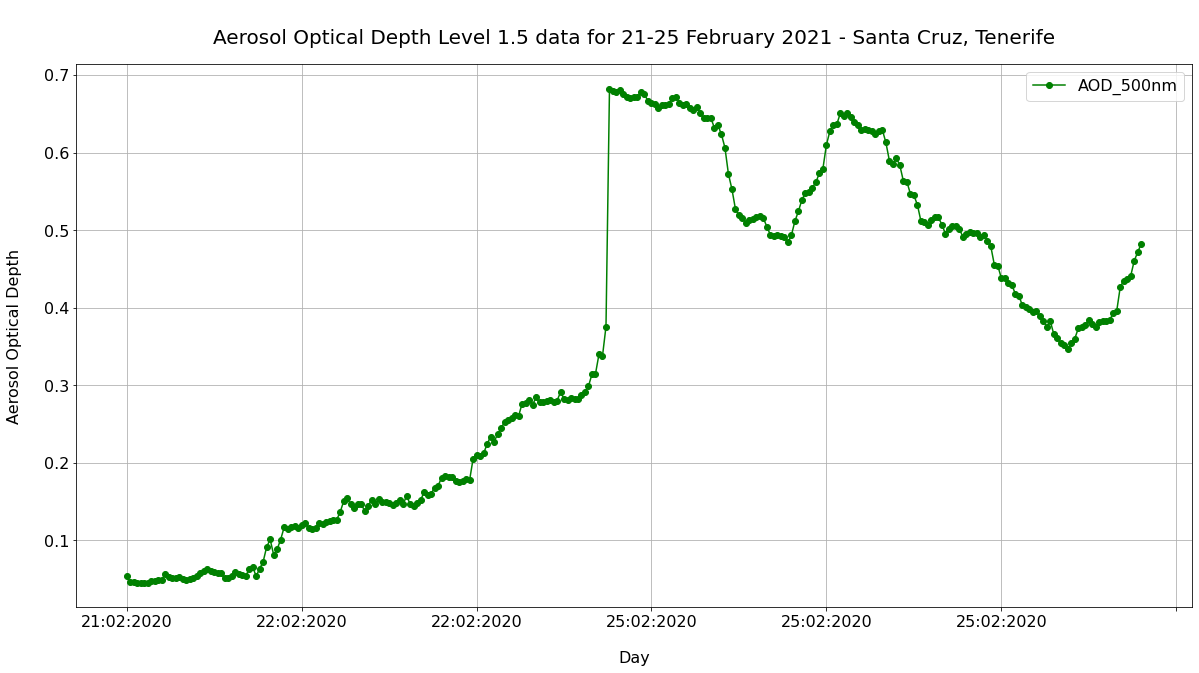

In [16]:
# Initiate a matplotlib figure
fig = plt.figure(figsize=(20,10))
ax=plt.axes()

# Select pandas dataframe columns and define a line plot
df.filter(['AOD_500nm']).plot(ax=ax, style='o-', color='green' )


# Set title and axes lable information
plt.title('\nAerosol Optical Depth Level 1.5 data for 21-25 February 2021 - Santa Cruz, Tenerife', fontsize=20, pad=20)
plt.ylabel('Aerosol Optical Depth\n', fontsize=16)
plt.xlabel('\nDay', fontsize=16)

# Format the axes ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add additionally a legend and grid to the plot
plt.legend(fontsize=16,loc=0)
plt.grid()

<br>

### <a id='resample_aeronet'></a>3. Resample AERONET data to a 3-hourly resolution

Above you see that it seems we do not have observations for 23rd and 24th February 2020 for the Santa Cruz station in Tenerife. A closer inspection of the index entry confirms that we only have measurements for 21st, 22nd and 25th.

In [17]:
df.index.values

array(['21:02:2020', '21:02:2020', '21:02:2020', '21:02:2020',
       '21:02:2020', '21:02:2020', '21:02:2020', '21:02:2020',
       '21:02:2020', '21:02:2020', '21:02:2020', '21:02:2020',
       '21:02:2020', '21:02:2020', '21:02:2020', '21:02:2020',
       '21:02:2020', '21:02:2020', '21:02:2020', '21:02:2020',
       '21:02:2020', '21:02:2020', '21:02:2020', '21:02:2020',
       '21:02:2020', '21:02:2020', '21:02:2020', '21:02:2020',
       '21:02:2020', '21:02:2020', '21:02:2020', '21:02:2020',
       '21:02:2020', '21:02:2020', '21:02:2020', '21:02:2020',
       '21:02:2020', '21:02:2020', '21:02:2020', '21:02:2020',
       '21:02:2020', '21:02:2020', '21:02:2020', '21:02:2020',
       '21:02:2020', '22:02:2020', '22:02:2020', '22:02:2020',
       '22:02:2020', '22:02:2020', '22:02:2020', '22:02:2020',
       '22:02:2020', '22:02:2020', '22:02:2020', '22:02:2020',
       '22:02:2020', '22:02:2020', '22:02:2020', '22:02:2020',
       '22:02:2020', '22:02:2020', '22:02:2020', '22:02

<br>

From the dataframe above, let us only select the columns of interest for us. This makes the handling of the dataframe much easier. The columns of interest are: `Time(hh:mm:ss)` and `AOD_500nm` and you can use the function `filter()` to select specific columns.

In [18]:
aeronet_ts = df.filter(['Time(hh:mm:ss)','AOD_500nm'])
aeronet_ts

,Time(hh:mm:ss),AOD_500nm
Date(dd:mm:yyyy),,
21:02:2020,08:22:46,0.053515
21:02:2020,08:25:22,0.046500
21:02:2020,08:28:46,0.045808
21:02:2020,08:30:39,0.045296
21:02:2020,08:33:09,0.045245
...,...,...
25:02:2020,18:06:09,0.436686
25:02:2020,18:09:31,0.441193
25:02:2020,18:13:14,0.460659


The next step is to create an index as `DateTimeIndex`. For this, we want to first combine the index entries (date) and time stamp entries of the column `Time(hh:mm:ss)`. We can do this simply by redefining the data frame's index and combining both with adding the two columns together as a string.

In a second step, we then convert the newly created index entry to a `DateTimeIndex` format with the function `to_datetime()`. Important here, you have to specify the format of combined index string.

In [19]:
aeronet_ts.index = aeronet_ts.index + ' ' + aeronet_ts['Time(hh:mm:ss)']
aeronet_ts.index = pd.to_datetime(aeronet_ts.index, format = '%d:%m:%Y %H:%M:%S')
aeronet_ts

,Time(hh:mm:ss),AOD_500nm
2020-02-21 08:22:46,08:22:46,0.053515
2020-02-21 08:25:22,08:25:22,0.046500
2020-02-21 08:28:46,08:28:46,0.045808
2020-02-21 08:30:39,08:30:39,0.045296
2020-02-21 08:33:09,08:33:09,0.045245
...,...,...
2020-02-25 18:06:09,18:06:09,0.436686
2020-02-25 18:09:31,18:09:31,0.441193
2020-02-25 18:13:14,18:13:14,0.460659
2020-02-25 18:15:09,18:15:09,0.471839


<br>

The MONARCH model has a three hourly resolution. For this reason, we have to adjust the temporal resolution of the AERONET observations and resample the data frame to a three hourly temporal resolution. Below, we use the function `resample()` and create the average of every 3-hours. The resulting dataframe has 37 row entries.

In [20]:
aeronet_ts_resample = aeronet_ts.resample('3H').mean()
aeronet_ts_resample

,AOD_500nm
2020-02-21 06:00:00,0.047250
2020-02-21 09:00:00,0.054734
2020-02-21 12:00:00,0.061003
2020-02-21 15:00:00,0.092615
2020-02-21 18:00:00,NaN
2020-02-21 21:00:00,NaN
2020-02-22 00:00:00,NaN
2020-02-22 03:00:00,NaN
2020-02-22 06:00:00,0.117495
2020-02-22 09:00:00,0.147488


<br>

### <a id='load_model_timeseries'></a>4. Load time series of the forecasts from CAMS and the MONARCH model

We can now load the time-series information of the CAMS and the MONARCH model forecasts for Santa Cruz, Tenerife. The time-series has been saved as csv file from yesterday's assignment (see [here](../day_1/day1_assignment_solution.ipynb#ts_cams)).
The time-series is available under `../data/sdswas_ts.csv` and can be loaded as pandas.DataFrame with the function `read_csv()`.

The next step is then to convert the index of the loaded dataframe into a `DateTimeIndex` format, as this allows us to combine the different time-series.

In [21]:
sdswas_ts = pd.read_csv('../data/sdswas_ts.csv')
sdswas_ts.index = sdswas_ts['time']
sdswas_ts.index = pd.to_datetime(sdswas_ts.index, format = '%Y-%m-%d %H:%M:%S')
sdswas_ts

,time,lon,lat,od550_dust
time,,,,
2020-02-21 12:00:00,2020-02-21 12:00:00,-16.333335,28.33333,0.000058
2020-02-21 15:00:00,2020-02-21 15:00:00,-16.333335,28.33333,0.000019
2020-02-21 18:00:00,2020-02-21 18:00:00,-16.333335,28.33333,0.000027
2020-02-21 21:00:00,2020-02-21 21:00:00,-16.333335,28.33333,0.000207
2020-02-22 00:00:00,2020-02-22 00:00:00,-16.333335,28.33333,0.000890
2020-02-22 03:00:00,2020-02-22 03:00:00,-16.333335,28.33333,0.001751
2020-02-22 06:00:00,2020-02-22 06:00:00,-16.333335,28.33333,0.009111
2020-02-22 09:00:00,2020-02-22 09:00:00,-16.333335,28.33333,0.050932
2020-02-22 12:00:00,2020-02-22 12:00:00,-16.333335,28.33333,0.203418


<br>

We repeat the same process for the time-series of the CAMS forecasts. We first read the csv file under `../data/cams_ts.csv` with the function `read_csv()`. Then, we convert the index into a `DateTimeIndex` format.

In [22]:
cams_ts = pd.read_csv('../data/cams_ts.csv')
cams_ts.index = cams_ts['time']
cams_ts.index = pd.to_datetime(cams_ts.index, format='%Y-%m-%d %H:%M:%S')
cams_ts

,time,longitude,latitude,duaod550
time,,,,
2020-02-21 12:00:00,2020-02-21 12:00:00,-16.4,28.6,0.000568
2020-02-21 15:00:00,2020-02-21 15:00:00,-16.4,28.6,0.000568
2020-02-21 18:00:00,2020-02-21 18:00:00,-16.4,28.6,0.001460
2020-02-21 21:00:00,2020-02-21 21:00:00,-16.4,28.6,0.002422
2020-02-22 00:00:00,2020-02-22 00:00:00,-16.4,28.6,0.005306
2020-02-22 03:00:00,2020-02-22 03:00:00,-16.4,28.6,0.011280
2020-02-22 06:00:00,2020-02-22 06:00:00,-16.4,28.6,0.080772
2020-02-22 09:00:00,2020-02-22 09:00:00,-16.4,28.6,0.203139
2020-02-22 12:00:00,2020-02-22 12:00:00,-16.4,28.6,0.335806


<br>

### <a id='compare_model_observations'></a> 5. Visually compare model forecasts with AERONET observations

All the three time-series (`aeronet_ts`, `sdswas_ts` and `cams_ts`) have now the same temporal resolution. The `DateTimeIndex` format allows for an efficient handling of time-series information and also allows us to combine the three time-series into one pandas.DataFrame. We can use the function `join()` and combine the two data frames `aeronet_ts` and `sdswas_ts`. We can repeat the process to join the third column from the `cams_ts`.

The resulting dataframe has 37 row entries and three columns.

In [23]:
df_merged = aeronet_ts_resample.join(sdswas_ts['od550_dust'])
df_merged = df_merged.join(cams_ts['duaod550'])
df_merged

,AOD_500nm,od550_dust,duaod550
2020-02-21 06:00:00,0.047250,NaN,NaN
2020-02-21 09:00:00,0.054734,NaN,NaN
2020-02-21 12:00:00,0.061003,0.000058,0.000568
2020-02-21 15:00:00,0.092615,0.000019,0.000568
2020-02-21 18:00:00,NaN,0.000027,0.001460
2020-02-21 21:00:00,NaN,0.000207,0.002422
2020-02-22 00:00:00,NaN,0.000890,0.005306
2020-02-22 03:00:00,NaN,0.001751,0.011280
2020-02-22 06:00:00,0.117495,0.009111,0.080772
2020-02-22 09:00:00,0.147488,0.050932,0.203139


<br>

The last step is now to plot the three columns of the pandas.DataFrame `df_merged` as three individual line plots.

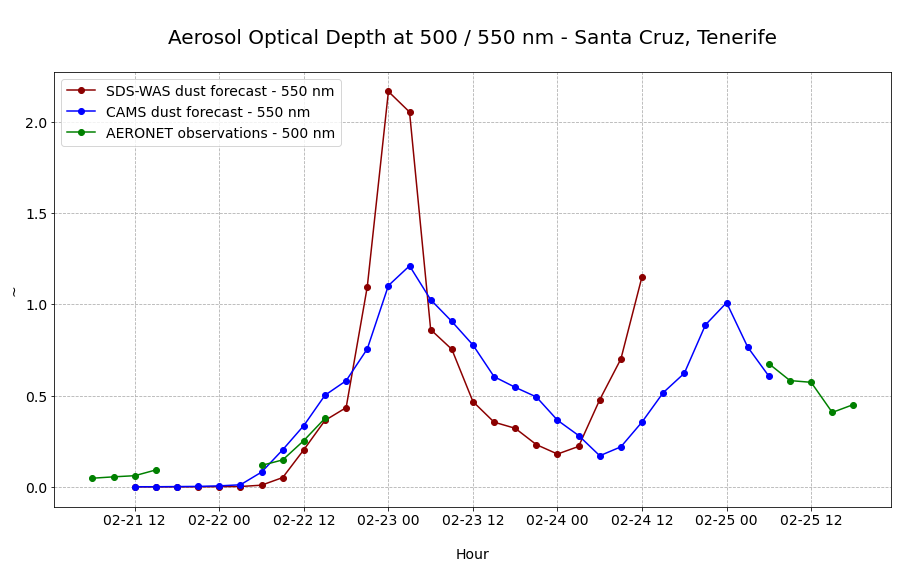

In [24]:
# Initiate a figure
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

# Define the plotting function
ax.plot(df_merged.od550_dust, 'o-', color='darkred',  label='SDS-WAS dust forecast - 550 nm')
ax.plot(df_merged.duaod550, 'o-', color='blue', label='CAMS dust forecast - 550 nm')
ax.plot(df_merged.AOD_500nm, 'o-', color='green', label='AERONET observations - 500 nm')

# Customize the title and axes lables
ax.set_title('\nAerosol Optical Depth at 500 / 550 nm - Santa Cruz, Tenerife\n', fontsize=20)
ax.set_ylabel('~', fontsize=14)
ax.set_xlabel('\nHour', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

plt.legend(fontsize=14, loc=2)


<br>

The plot above shows you that AERONET station observations can be used to evaluate model predictions - however, station observations show often also quite a few gaps. The strong dust event over Tenerife on 23/24 February 2021 was not measured at all by the AERONET station. For such gaps, model data are helpful to bridge such gaps. But the plot above shows also that the two models predicted especially the intensity of the dust event differently.

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='left' width='20%'><br><br><br><br>
<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.